In [1]:
import WindyGridWorld
import random
import numpy as np
import matplotlib.pyplot as plt
import PF_Plus
import IO_Tool

In [2]:
def getFeatures(state,action):
    vect = np.zeros((320,1))
    if action == actions[0]:
        act_val=0
    elif action == actions[1]:
        act_val=1
    elif action == actions[2]:
        act_val=2
    elif action == actions[3]:
        act_val=3
    else:
        print("UNKNOWN ACTION",action)
    s_val = state[0]+10*state[1]+act_val*80
    vect[s_val]=1
    return vect

In [3]:
def calc_g_hat_theta(A_mat,y_vect):
    return - np.matmul(np.transpose(A_mat),y_vect.reshape((d,1)))
def calc_g_hat_y(b_vect,A_mat,theta_vect,M_mat,y_vect):
    a1 =-b_vect
    a2 =np.matmul(A_mat,theta_vect.reshape((d,1)))
    a3 =np.matmul(M_mat,y_vect.reshape((d,1)))
    return a1+a2+a3

In [4]:
def getQVal(features,weights):
    return np.matmul(features.reshape((1,d)),weights.reshape((d,1)))

In [5]:
mdp = WindyGridWorld.mdp()
actions = ["UP","DOWN","LEFT","RIGHT"]
d = 320

In [6]:
# Initial Policy
epsillon = 0.5
theta = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))
y = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))
policy = {}
for i in range(10):
    for j in range(8):
        best = None
        best_action=None
        for a in actions:
            q = getQVal(getFeatures((i,j),a),theta)
            if best==None or q>best:
                best = q
                best_action = a
        policy[(i,j)]=best_action

In [7]:
Transitions = []
state = mdp.getStartState()
while 1:
    prev = state
    a = random.choice(actions)
    state,r = mdp.getTransition(state,a)
    Transitions.append((prev,state,a,r))
    if r==0:
        break

In [8]:
x1,y1 = np.meshgrid(np.arange(0, 10, 1), np.arange(0, 8, 1))

In [9]:
u = np.zeros(y1.shape)
v = np.zeros(y1.shape)

In [10]:
for i in range(10):
    for j in range(8):
        if policy[(i,j)]=="UP":
            u[j,i]=0
            v[j,i]=0.1
        elif policy[(i,j)]=="DOWN":
            u[j,i]=0
            v[j,i]=-0.1
        elif policy[(i,j)]=="RIGHT":
            u[j,i]=0.1
            v[j,i]=0
        elif policy[(i,j)]=="LEFT":
            u[j,i]=-0.1
            v[j,i]=0
        else:
            print("UNKNOWN ACTION",policy[(i,j)])


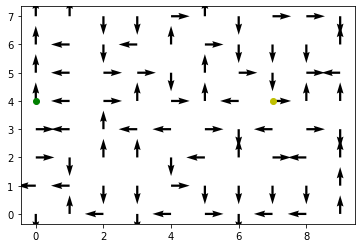

In [11]:
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [12]:
for i in range(10):
    for j in range(8):
        windEffect = mdp.getWind(i)
        v[j,i] += windEffect*0.1

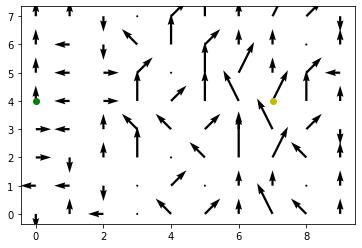

In [13]:
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [14]:
# Exp policy fully random
b_prob = 1/4
# Current policy -> policy, with eps greedy action selection: Each non fav is with prob p = eps/4
p_fav = 1-epsillon+epsillon/4
p_others = epsillon/4
ratio_fav = p_fav/b_prob
ratio_others = p_others/b_prob

In [15]:
discount = 1.0

In [16]:
# Sarsa

In [17]:
A = []
b = []
M = []
for sample in Transitions:
    (prev,new,a,r) = sample
    oldFeatures = getFeatures(prev,a)
    newFeatures = getFeatures(new,policy[new])
    if a == policy[prev]:
        ratio = ratio_fav
    else:
        ratio = ratio_others
    temp = oldFeatures - discount * newFeatures
    
    result_A = np.matmul(ratio*oldFeatures.reshape((d,1)),temp.reshape((1,d)))
    A.append(result_A)
    result_b = r*ratio*oldFeatures
    b.append(result_b)
    result_M = np.matmul(oldFeatures.reshape((d,1)),oldFeatures.reshape((1,d)))
    M.append(result_M)

In [18]:
l = len(b)-1
A_current = A.pop(0)
b_current = b.pop(0)
M_current = M.pop(0)
g_hat_theta = calc_g_hat_theta(A_current,y)
g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
PF_Plus_theta = PF_Plus.Algo(g_hat_theta,d)
PF_Plus_y = PF_Plus.Algo(g_hat_y,d)

In [19]:
print(l)
checkpoints = [int(l*i/5)for i in range(1,5)]
for i in range(l):
    if i in checkpoints:
        print(str(int(100*i/l))+"% done")
    A_current = A.pop(0)
    b_current = b.pop(0)
    M_current = M.pop(0)
    theta = PF_Plus_theta.getWeight()
    y = PF_Plus_y.getWeight()
    g_hat_theta = calc_g_hat_theta(A_current,y)
    g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
    PF_Plus_theta.update(g_hat_theta)
    PF_Plus_y.update(g_hat_y)
theta = PF_Plus_theta.getWeight()

63
19% done
39% done
58% done
79% done


<BarContainer object of 320 artists>

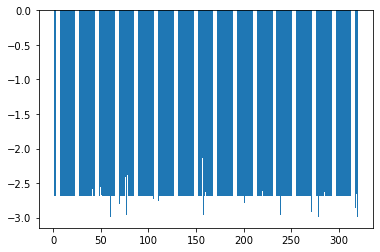

In [20]:
plt.bar(range(1,d+1),theta[:,0])

In [21]:
for i in range(10):
    for j in range(8):
        best = None
        best_action=None
        for a in actions:
            q = getQVal(getFeatures((i,j),a),theta)
            if best==None or q>best:
                best = q
                best_action = a
        policy[(i,j)]=best_action

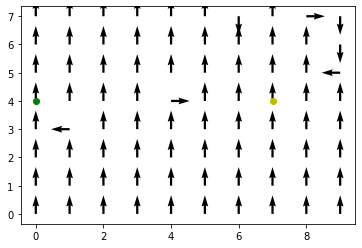

In [22]:
x1,y1 = np.meshgrid(np.arange(0, 10, 1), np.arange(0, 8, 1))
u = np.zeros(y1.shape)
v = np.zeros(y1.shape)
for i in range(10):
    for j in range(8):
        if policy[(i,j)]=="UP":
            u[j,i]=0
            v[j,i]=0.1
        elif policy[(i,j)]=="DOWN":
            u[j,i]=0
            v[j,i]=-0.1
        elif policy[(i,j)]=="RIGHT":
            u[j,i]=0.1
            v[j,i]=0
        elif policy[(i,j)]=="LEFT":
            u[j,i]=-0.1
            v[j,i]=0
        else:
            print("UNKNOWN ACTION",policy[(i,j)])


plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [23]:
elems = []
for i in range(10):
    for j in range(8):
        elems.append(policy[(i,j)])
writer = IO_Tool.Writer()

writer.write(elems,"policy.txt")

In [24]:

#writer.write(y,"ys.txt")
#writer.write(theta,"thetas.txt")

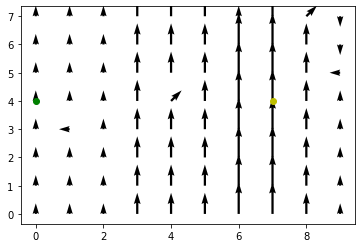

In [25]:
for i in range(10):
    for j in range(8):
        windEffect = mdp.getWind(i)
        v[j,i] += windEffect*0.1
        
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [26]:
epsillon = epsillon*3/4
Transitions = []
state = mdp.getStartState()
epCount = 1
for i in range(epCount):
    while 1:
        prev = state
        a = random.choice(actions)
        state,r = mdp.getTransition(state,a)
        Transitions.append((prev,state,a,r))
        if r==0:
            break
    state = mdp.getStartState()

In [27]:
# Exp policy fully random
b_prob = 1/4
# Current policy -> policy, with eps greedy action selection: Each non fav is with prob p = eps/4
p_fav = 1-epsillon+epsillon/4
p_others = epsillon/4
ratio_fav = p_fav/b_prob
ratio_others = p_others/b_prob

In [28]:
A = []
b = []
M = []
for sample in Transitions:
    (prev,new,a,r) = sample
    oldFeatures = getFeatures(prev,a)
    newFeatures = getFeatures(new,policy[new])
    if a == policy[prev]:
        ratio = ratio_fav
    else:
        ratio = ratio_others
    temp = oldFeatures - discount * newFeatures
    
    result_A = np.matmul(ratio*oldFeatures.reshape((d,1)),temp.reshape((1,d)))
    A.append(result_A)
    result_b = r*ratio*oldFeatures
    b.append(result_b)
    result_M = np.matmul(oldFeatures.reshape((d,1)),oldFeatures.reshape((1,d)))
    M.append(result_M)

In [29]:
#theta = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))
#y = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))

In [30]:
l = len(b)#-1
"""
A_current = A.pop(0)
b_current = b.pop(0)
M_current = M.pop(0)
g_hat_theta = calc_g_hat_theta(A_current,y)
g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
"""
#PF_Plus_theta = PF_Plus.Algo(g_hat_theta,d)
#PF_Plus_y = PF_Plus.Algo(g_hat_y,d)

'\nA_current = A.pop(0)\nb_current = b.pop(0)\nM_current = M.pop(0)\ng_hat_theta = calc_g_hat_theta(A_current,y)\ng_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)\n'

In [31]:
print(l)
checkpoints = [int(l*i/5)for i in range(1,5)]
for i in range(l):
    if i in checkpoints:
        print(str(int(100*i/l))+"% done")
    A_current = A.pop(0)
    b_current = b.pop(0)
    M_current = M.pop(0)
    theta = PF_Plus_theta.getWeight()
    y = PF_Plus_y.getWeight()
    g_hat_theta = calc_g_hat_theta(A_current,y)
    g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
    PF_Plus_theta.update(g_hat_theta)
    PF_Plus_y.update(g_hat_y)
#theta = PF_Plus_theta.getWeight()

13319
19% done
39% done
59% done
79% done


In [32]:
for i in range(10):
    for j in range(8):
        best = None
        best_action=None
        for a in actions:
            q = getQVal(getFeatures((i,j),a),theta)
            if best==None or q>best:
                best = q
                best_action = a
        policy[(i,j)]=best_action

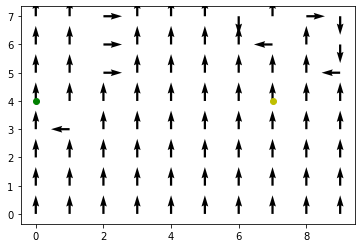

In [33]:
u = np.zeros(y1.shape)
v = np.zeros(y1.shape)
for i in range(10):
    for j in range(8):
        if policy[(i,j)]=="UP":
            u[j,i]=0
            v[j,i]=0.1
        elif policy[(i,j)]=="DOWN":
            u[j,i]=0
            v[j,i]=-0.1
        elif policy[(i,j)]=="RIGHT":
            u[j,i]=0.1
            v[j,i]=0
        elif policy[(i,j)]=="LEFT":
            u[j,i]=-0.1
            v[j,i]=0
        else:
            print("UNKNOWN ACTION",policy[(i,j)])


plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

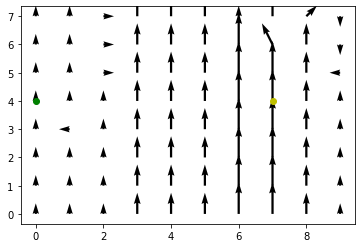

In [34]:
for i in range(10):
    for j in range(8):
        windEffect = mdp.getWind(i)
        v[j,i] += windEffect*0.1
        
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [35]:
epsillon = epsillon*3/4
Transitions = []
state = mdp.getStartState()
epCount = 4
for i in range(epCount):
    while 1:
        prev = state
        a = random.choice(actions)
        state,r = mdp.getTransition(state,a)
        Transitions.append((prev,state,a,r))
        if r==0:
            break
    state = mdp.getStartState()

In [36]:
# Exp policy fully random
b = 1/4
# Current policy -> policy, with eps greedy action selection: Each non fav is with prob p = eps/4
p_fav = 1-epsillon+epsillon/4
p_others = epsillon/4
ratio_fav = p_fav/b
ratio_others = p_others/b

In [37]:
len(Transitions)

33660

In [38]:
#theta = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))
#y = np.array([random.uniform(-1,1) for i in range(d)]).reshape((d,1))
"""
sample = Transitions.pop(0)
(prev,new,a,r) = sample
oldFeatures = getFeatures(prev,a)
newFeatures = getFeatures(new,policy[new])
if a == policy[prev]:
    ratio = ratio_fav
else:
    ratio = ratio_others
temp = oldFeatures - discount * newFeatures

A_current = np.matmul(ratio*oldFeatures.reshape((d,1)),temp.reshape((1,d)))
b_current = r*ratio*oldFeatures
M_current = np.matmul(oldFeatures.reshape((d,1)),oldFeatures.reshape((1,d)))

g_hat_theta = calc_g_hat_theta(A_current,y)
g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
#PF_Plus_theta = PF_Plus.Algo(g_hat_theta,d)
#PF_Plus_y = PF_Plus.Algo(g_hat_y,d)

"""
l = len(Transitions)
print(l)
checkpoints = [int(l*i/5)for i in range(1,5)]



for sample in Transitions:
    #r_prev = r
        
    (prev,new,a,r) = sample
    oldFeatures = getFeatures(prev,a)
    newFeatures = getFeatures(new,policy[new])
    if a == policy[prev]:
        ratio = ratio_fav
    else:
        ratio = ratio_others
    temp = oldFeatures - discount * newFeatures
    
    A_current = np.matmul(ratio*oldFeatures.reshape((d,1)),temp.reshape((1,d)))
    b_current = r*ratio*oldFeatures
    M_current = np.matmul(oldFeatures.reshape((d,1)),oldFeatures.reshape((1,d)))
    i+=1
    if i in checkpoints:
        print(str(int(100*i/l))+"% done")
    theta = PF_Plus_theta.getWeight()
    y = PF_Plus_y.getWeight()
    g_hat_theta = calc_g_hat_theta(A_current,y)
    g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
    #if r_prev == 0:
    #    PF_Plus_theta = PF_Plus.Algo(g_hat_theta,d)
    #    PF_Plus_y = PF_Plus.Algo(g_hat_y,d)
    #    continue
    PF_Plus_theta.update(g_hat_theta)
    PF_Plus_y.update(g_hat_y)
    
#theta = PF_Plus_theta.getWeight()

33660
20% done
40% done
60% done
80% done


In [39]:
for i in range(10):
    for j in range(8):
        best = None
        best_action=None
        for a in actions:
            q = getQVal(getFeatures((i,j),a),theta)
            if best==None or q>best:
                best = q
                best_action = a
        policy[(i,j)]=best_action

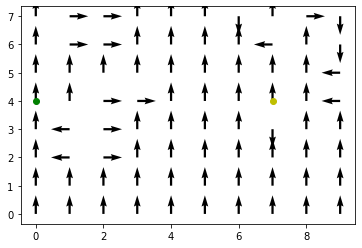

In [40]:
u = np.zeros(y1.shape)
v = np.zeros(y1.shape)
for i in range(10):
    for j in range(8):
        if policy[(i,j)]=="UP":
            u[j,i]=0
            v[j,i]=0.1
        elif policy[(i,j)]=="DOWN":
            u[j,i]=0
            v[j,i]=-0.1
        elif policy[(i,j)]=="RIGHT":
            u[j,i]=0.1
            v[j,i]=0
        elif policy[(i,j)]=="LEFT":
            u[j,i]=-0.1
            v[j,i]=0
        else:
            print("UNKNOWN ACTION",policy[(i,j)])


plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

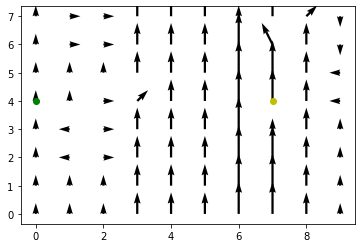

In [41]:
for i in range(10):
    for j in range(8):
        windEffect = mdp.getWind(i)
        v[j,i] += windEffect*0.1
        
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [44]:
epsillon = epsillon*3/4
Transitions = []
state = mdp.getStartState()
epCount = 10
for i in range(epCount):
    while 1:
        prev = state
        a = random.choice(actions)
        state,r = mdp.getTransition(state,a)
        Transitions.append((prev,state,a,r))
        if r==0:
            break
    state = mdp.getStartState()
len(Transitions)

51318

In [45]:
# Exp policy fully random
b = 1/4
# Current policy -> policy, with eps greedy action selection: Each non fav is with prob p = eps/4
p_fav = 1-epsillon+epsillon/4
p_others = epsillon/4
ratio_fav = p_fav/b
ratio_others = p_others/b

In [46]:
l = len(Transitions)
print(l)
checkpoints = [int(l*i/5)for i in range(1,5)]



for sample in Transitions:
    #r_prev = r
        
    (prev,new,a,r) = sample
    oldFeatures = getFeatures(prev,a)
    newFeatures = getFeatures(new,policy[new])
    if a == policy[prev]:
        ratio = ratio_fav
    else:
        ratio = ratio_others
    temp = oldFeatures - discount * newFeatures
    
    A_current = np.matmul(ratio*oldFeatures.reshape((d,1)),temp.reshape((1,d)))
    b_current = r*ratio*oldFeatures
    M_current = np.matmul(oldFeatures.reshape((d,1)),oldFeatures.reshape((1,d)))
    i+=1
    if i in checkpoints:
        print(str(int(100*i/l))+"% done")
    theta = PF_Plus_theta.getWeight()
    y = PF_Plus_y.getWeight()
    g_hat_theta = calc_g_hat_theta(A_current,y)
    g_hat_y = calc_g_hat_y(b_current,A_current,theta,M_current,y)
    #if r_prev == 0:
    #    PF_Plus_theta = PF_Plus.Algo(g_hat_theta,d)
    #    PF_Plus_y = PF_Plus.Algo(g_hat_y,d)
    #    continue
    PF_Plus_theta.update(g_hat_theta)
    PF_Plus_y.update(g_hat_y)
    

51318
19% done
39% done
59% done
79% done


In [47]:
for i in range(10):
    for j in range(8):
        best = None
        best_action=None
        for a in actions:
            q = getQVal(getFeatures((i,j),a),theta)
            if best==None or q>best:
                best = q
                best_action = a
        policy[(i,j)]=best_action

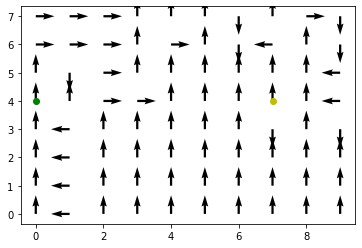

In [48]:
u = np.zeros(y1.shape)
v = np.zeros(y1.shape)
for i in range(10):
    for j in range(8):
        if policy[(i,j)]=="UP":
            u[j,i]=0
            v[j,i]=0.1
        elif policy[(i,j)]=="DOWN":
            u[j,i]=0
            v[j,i]=-0.1
        elif policy[(i,j)]=="RIGHT":
            u[j,i]=0.1
            v[j,i]=0
        elif policy[(i,j)]=="LEFT":
            u[j,i]=-0.1
            v[j,i]=0
        else:
            print("UNKNOWN ACTION",policy[(i,j)])


plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

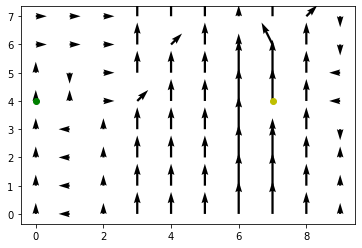

In [49]:
for i in range(10):
    for j in range(8):
        windEffect = mdp.getWind(i)
        v[j,i] += windEffect*0.1
        
plt.quiver(x1,y1,u,v)
plt.plot(0,4,"go")
plt.plot(7,4,"yo")

In [50]:

Transitions = []
state = mdp.getStartState()
epCount = 1
for i in range(epCount):
    while 1:
        prev = state
        if random.uniform(0,1) > epsillon:
            a = policy[state]
        else:
            a = random.choice(actions)
        state,r = mdp.getTransition(state,a)
        Transitions.append((prev,state,a,r))
        if r==0:
            break
    state = mdp.getStartState()

In [51]:
len(Transitions)

11235054